In [1]:
import pickle
import numpy as np

file_path = "../data/raw/s01.dat"

with open(file_path, "rb") as f:
    data = pickle.load(f, encoding="latin1")

print("Keys:", data.keys())
print("Data shape:", data["data"].shape)
print("Labels shape:", data["labels"].shape)


Keys: dict_keys(['labels', 'data'])
Data shape: (40, 40, 8064)
Labels shape: (40, 4)


In [2]:
eeg_data = data["data"][:, :32, :]

print("EEG shape:", eeg_data.shape)


EEG shape: (40, 32, 8064)


In [3]:
valence = data["labels"][:, 0]
arousal = data["labels"][:, 1]

cognitive_labels = []

for v, a in zip(valence, arousal):
    if v >= 5 and a >= 5:
        cognitive_labels.append(0)   # Focused
    elif v < 5 and a >= 5:
        cognitive_labels.append(1)   # Stress
    elif v >= 5 and a < 5:
        cognitive_labels.append(2)   # Relaxed
    else:
        cognitive_labels.append(3)   # Fatigue

cognitive_labels = np.array(cognitive_labels)

print("Labels:", cognitive_labels)


Labels: [0 0 0 1 2 2 2 2 3 3 3 3 3 3 1 0 1 0 0 0 0 2 2 0 0 0 0 3 3 3 1 1 3 1 1 1 1
 1 1 0]


Matplotlib is building the font cache; this may take a moment.


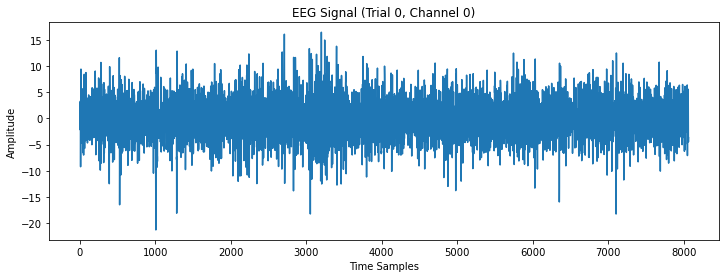

In [4]:
import matplotlib.pyplot as plt

trial = 0
channel = 0

signal = eeg_data[trial, channel]

plt.figure(figsize=(12,4))
plt.plot(signal)
plt.title("EEG Signal (Trial 0, Channel 0)")
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.show()


The above graph basically shows the electrical activity of neurons firing inside the brain. EEG electrodes measures the tiny voltage changes on the scalp caused by synchronized neuron activity.
Typical EEG range:
±5 to ±100 µV
Our graph showing:
-20 to +15

In [5]:
np.save("../data/processed/eeg.npy", eeg_data)
np.save("../data/processed/labels.npy", cognitive_labels)


In [ ]:
from scipy.signal import butter, filtfilt
#butter()
#Creates filter coefficients.
#filtfilt()
#Applies filter forward + backward, prevents phase shift

In [7]:
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    
    # Nyquist frequency
    nyquist = 0.5 * fs
    
    # Normalize cutoff frequencies
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Create filter
    b, a = butter(order, [low, high], btype='band')
    
    # Apply filter
    filtered_signal = filtfilt(b, a, signal)
    
    return filtered_signal


In [8]:
sampling_freq = 128

raw_signal = eeg_data[0, 0]

filtered_signal = bandpass_filter(
    raw_signal,
    lowcut=0.5,
    highcut=45,
    fs=sampling_freq
)


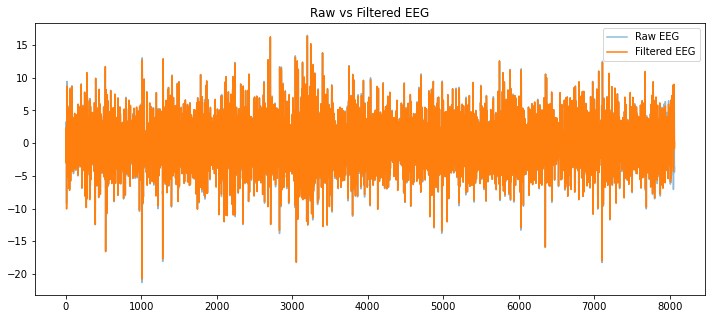

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(raw_signal, label="Raw EEG", alpha=0.5)
plt.plot(filtered_signal, label="Filtered EEG")

plt.legend()
plt.title("Raw vs Filtered EEG")
plt.show()


In [10]:
alpha_signal = bandpass_filter(
    raw_signal,
    lowcut=8,
    highcut=13,
    fs=sampling_freq
)


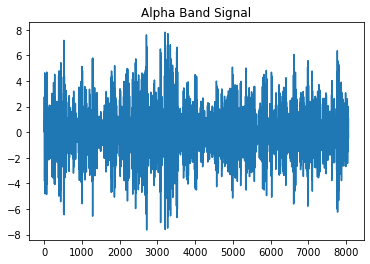

In [11]:
plt.plot(alpha_signal)
plt.title("Alpha Band Signal")
plt.show()


In [12]:
import numpy as np

def band_power(signal):
    return np.mean(signal ** 2)


In [13]:
alpha_power = band_power(alpha_signal)

print("Alpha Power:", alpha_power)


Alpha Power: 3.8432970889538725


In [14]:
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30),
    "gamma": (30, 45)
}


In [15]:
def band_power(signal):
    return np.mean(signal ** 2)


In [17]:
def extract_trial_features(trial_data, fs):
    
    trial_features = []
    
    for channel_signal in trial_data:
        
        for band_name, (low, high) in bands.items():
            
            band_signal = bandpass_filter(
                channel_signal,
                low,
                high,
                fs
            )
            
            power = band_power(band_signal)
            trial_features.append(power)
    
    return trial_features


In [18]:
feature_matrix = []

for trial in eeg_data:
    
    features = extract_trial_features(trial, sampling_freq)
    feature_matrix.append(features)

feature_matrix = np.array(feature_matrix)


In [19]:
print(feature_matrix.shape)


(40, 160)


In [20]:
np.save("../data/processed/features.npy", feature_matrix)
np.save("../data/processed/labels.npy", cognitive_labels)


In [21]:
def time_domain_features(signal):
    
    mean_val = np.mean(signal)
    variance_val = np.var(signal)
    
    return [mean_val, variance_val]


In [23]:
from scipy.signal import welch
def compute_psd(signal, fs):
    
    freqs, psd = welch(signal, fs=fs)
    
    return freqs, psd


In [24]:
def band_power_psd(freqs, psd, low, high):
    
    band_mask = (freqs >= low) & (freqs <= high)
    
    power = np.trapz(psd[band_mask], freqs[band_mask])
    
    return power


In [25]:
def extract_channel_features(signal, fs):
    
    features = []
    
    # ----- Time domain -----
    features.extend(time_domain_features(signal))
    
    # ----- PSD -----
    freqs, psd = compute_psd(signal, fs)
    
    # ----- Band powers -----
    for band_name, (low, high) in bands.items():
        power = band_power_psd(freqs, psd, low, high)
        features.append(power)
    
    return features


In [26]:
def extract_trial_features(trial_data, fs):
    
    trial_features = []
    
    for channel_signal in trial_data:
        
        channel_features = extract_channel_features(
            channel_signal, fs
        )
        
        trial_features.extend(channel_features)
    
    return trial_features


In [27]:
feature_matrix = []

for trial in eeg_data:
    feature_matrix.append(
        extract_trial_features(trial, sampling_freq)
    )

feature_matrix = np.array(feature_matrix)

print(feature_matrix.shape)


(40, 224)


In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = scaler.fit_transform(feature_matrix)
y = cognitive_labels
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)


Feature matrix shape: (40, 224)
Labels shape: (40,)


In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.375
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.38         8
   macro avg       0.42      0.29      0.33         8
weighted avg       0.50      0.38      0.42         8



In [32]:
import pickle

with open("../data/processed/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
